# Machine Learning on Adult Census Income Dataset: Ryan Gomberg
## March 16, 2025

# Abstract

Machine learning has proven to be a potent and powerful tool in researching socioeconomic data. The **Adult Census Income Dataset**, taken from the U.S. Census Bureau, is a great application of binary classification. The label to be observed is whether an individual's income exceeds $50,000 per year based on demographic and employment differences. This study explores statistical patterns within our dataset and applies supervised/unsupervised machine learning methodologies including Principal Component Analysis (PCA) for trend testing, Logistic Regression for classification accuracy, and Random Forests for predictor importance. Prior to running each model, we label encoded, one-hot encoded, standardized numerical and categorical data, and splitting into test/train data as our main preprocessing measures. When evaluating our models, we assigned each of them to a different metric (explained variance, loss functions, accuracy) to gauge the strength of relationships between predictors and how well our model is predicting our test data. We concluded that PCA does not identify any strong correlations within our predictors and it may be more beneficial to select a subset of them within our training data (to eliminate any possible extraneous data). Additionally, unsupervised models promised reasonable accuracy (82.49\% for Logistic Regression and 85.92\%) for Random Forests, with Random Forests offering 3.43\% higher accuracy. Lastly, our Random Forest model reveals that continuous predictors, with the exception of relationship status, have the most influence on predicting an individual's aggregate income.

## Contents
1.  Overview of the Dataset, Importing the Data
2.  Preprocessing
3.  Exploratory Data Analysis
4.  Principal Component Analysis (PCA)
5.  Logistic Regression & K-Fold Cross Validation
6.  Random Forest and Decision Trees
7.  Conclusion

# 1. Overview of the Dataset, Importing the Data
We are using the "Adult" dataset from the UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/dataset/2/adult) which is a collection of American Census Data from 1994. The target label is a binary value classifying whether an individual's income is <=50k or >50k. There are 14 predictors present with a split of demographic and non-demographic components. The demographic components include age, workclass, education, education-num, marital-status, occupation, relationship, race, sex, and native-country. The non-demographic componets include fnlwgt, capital-gain, capital-loss, and hours-per-week. fnlwgt is a continous predictor whose value is a measure of the amout of people that the data represents, and it adjusts for over/undersampling, sampling errors, and non-responses. In total, there are 48,842 observations.

In [3]:
!pip install ucimlrepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Retrieving the data
from ucimlrepo import fetch_ucirepo

adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets

# 2. Preprocessing the Data

In order to perform machine learning techniques, we implemented the following changes to the dataset:

1.   Relabeled <=50k as 0 and >50k as 1 in the income data
2.   Standardized the data to have a mean of 0 and variance of 1. This is so that any derived weights and coefficients can be meaningfully compared
3.   Replaced missing values with 'NaN'
4.   Rewrote "education-level" as an ordinal predictor (e.g. 'Preschool', '1st-4th', ..., 'Doctorate')
5.   Divided the data into 70% training data and 30% testing data (Done in Section 3)

In [4]:
#Converting into a Data Frame
df = pd.DataFrame(adult.data.features)

#Replace missing values '?' with NaN
df.replace('?', np.nan, inplace=True)

#Ordinal encoding for level of education
ord_edu = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th',
            'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters',
            'Doctorate']
df['education'] = df['education'].astype(pd.CategoricalDtype(categories = ord_edu, ordered = True))

#Expressing income as numerical data (<=50k = 0, >50k = 1)
df['income'] = df['income'] = adult.data.targets['income'].str.strip().replace({'<=50K.': 0, '>50K.': 1, '<=50K': 0, '>50K': 1})

# 3. Exploratory Data Analysis

We constructed statistical models for the following predictors:
1.   Sex & Response Distribution
2.   Age Density Distribution
3.   Education Level Distribution
4.   Race Distribution
5.   Marital Status Distribution
6.   Hours per week between males and females

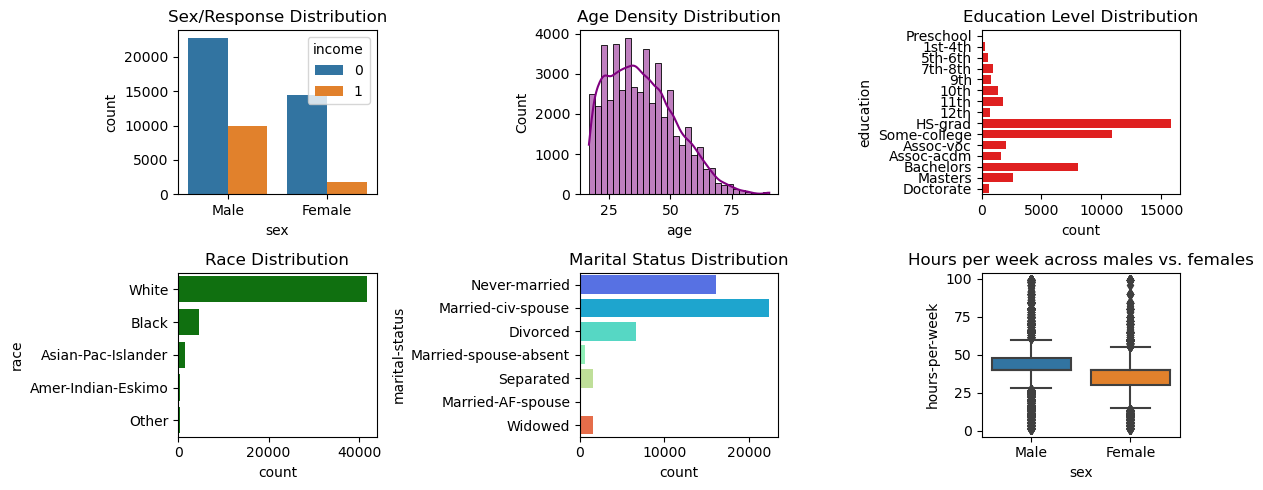

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))

#Histogram on income response between sex
sns.countplot(data = df, x = 'sex', hue = 'income', ax=axes[0, 0])
axes[0, 0].set_title("Sex/Response Distribution")

#Density distribution on age

dens = sns.histplot(data = df, bins=30, x = 'age', kde = True, color = 'purple', ax=axes[0, 1])
axes[0, 1].set_title("Age Density Distribution")

#Proportion of education levels

sns.countplot(data=df, y = 'education', color = 'red', ax=axes[0, 2])
axes[0, 2].set_title("Education Level Distribution")

#Proportion of race
sns.countplot(data = df, y = 'race', color = 'green', ax = axes[1, 0])
axes[1, 0].set_title("Race Distribution")

#Proportion of Marital Status
sns.countplot(data = df, y = 'marital-status', palette = 'rainbow', ax = axes[1, 1])
axes[1, 1].set_title("Marital Status Distribution")

#Boxplot on sex & hours-per-week
sns.boxplot(data = df, x = "sex", y = "hours-per-week", ax = axes[1, 2])
axes[1, 2].set_title("Hours per week across males vs. females")

#Encoding categorical predictors/Normalizing numerical predictors
X = df.drop(['income'], axis = 1)
y = df['income']

plt.tight_layout()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify = y)

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

1.   Significantly more males were included in the data with a significantly higher fraction of males having earned an income above \$50k.
2.   The ages of respondants ranged from 17 to 90 and the most common age was 36.
3.   A large majority of the respondants have at least completed high school with a large fraction of that having attempted and completed some college degree.
4.   White people are overly represented in this data, accounting for almost 40,000 of the observations. There could be signs of bias/skewness. 
5.   A majority of individuals were married, never married, or divorced at the time of this survey.
6.   Within our data, males, on average, work more hours per week compared to females.

In general, one could argue that there is gender and race imbalances within this dataset. 

# 4. Principal Component Analysis (PCA)
Our goal is to reduce the dimensions of our dataset while retaining as much **high dimensional** information as possible. This is generally obtained through an orthogonal projection function.

While the imported PCA submodule will do the steps for us, it is important to get a sense of the methodology.



1.   Standardize all predictors (already done in preprocessing)
2.   Compute covariance matrix to identify correlations between predictors
3.   Obtain eigenvectors of the covariance matrix - these are the **principal components**
4.   By projecting the original data onto the initial dataset, the new dataset is the “most relevant” information
5.    The new predictors (PCs) are now linear combinations of the initial predictors
6.    Principal components are ranked by contribution to overall explained variance, given by their eigenvalue

Ideally, we want 4-6 PC's, each containing moderate to strong correlations.

Recall that for unsupervised learning models, there is no label to be predicted. The reason for choosing PCA was partially influenced by this notion$-$to identify any patterns between predictors from the start, before even applying any unsupervised models. That way, we can capture any interactions and determine how that may influence the outcome in future models.

Unfortunately, there is no metric that can be computed empirically for unsupervised learning models. Therefore, we have to pay close attention to *trends* within our predictors.

We proceed by identifying the explained variance is partitioned in a PCA model with all of our predictors. The "psuedo-metric" we impose is achieving 90% of explained variance within our model.

In [6]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

cumsum = np.cumsum(pca.explained_variance_ratio_)

if np.any(cumsum >= 0.90):
    dim = np.argmax(cumsum >= 0.90) + 1
else:
    dim = X_pca.shape[1]

print('The number of dimensions required to preserve 90% of variance is', dim)

[0.14698127 0.10470652 0.09586563 0.07988325 0.07832342 0.07357941
 0.06741986 0.06569374 0.06176278 0.05948295 0.05016212 0.04890175
 0.03965034 0.02758696]
The number of dimensions required to preserve 90% of variance is 12


This does not appear to be good, for we need 12 components to explain 90% of our variance, suggesting that we cannot reliably reduce the dimensions without losing a lot of information. This is exemplified when each principal component contributes a decent amount of variance.

Now, we'll try fitting a new PCA object with 12 PC's. For each principal component, we can identify any correlations through a heatmap.

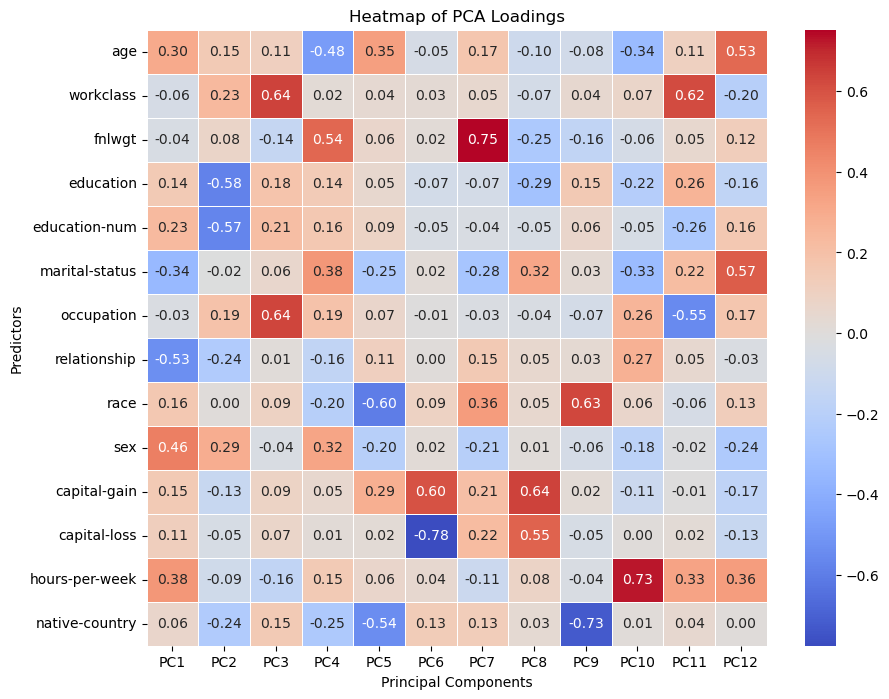

In [7]:
#Fitting a new PCA object with only 12 principal components
pca2 = PCA(n_components = 12)
pca2.fit_transform(X_train)
feature_names = X.columns.tolist()

#Contributions of predictors in each principal component
loadings = pd.DataFrame(
    pca2.components_.T,
    columns=[f'PC{i+1}' for i in range(pca2.n_components_)],
    index=feature_names
)
loadings.index = feature_names

plt.figure(figsize=(10, 8))
sns.heatmap(loadings, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Heatmap of PCA Loadings")
plt.xlabel("Principal Components")
plt.ylabel("Predictors")
plt.show()

Here, positive and negative contribution are colored red and blue, respectively. A stronger contribution indicaes a darker shade. A good PCA model would have a lot of strong correlations within the first few principal components, which does not agree with our results.

### Conclusions
We make the following remarks about our PCA model:


1.   There doesn’t appear to be any strong trends within our predictors. No single predictor overwhelmingly dominates any principal component
2.   We need 12 out of 14 PC’s to stay above 90% variability. Additionally, each PC has decent contribution towards the total variance. This is not ideal, as it suggests that the data does not have dominant patterns that can be easily separated
3.   The patterns between our predictors, if any exist, are a lot more intricate/complicated than we may have originally thought
4.   Could lower expectations for explained variance (ex. 70%) if we think there is a lot of noise in our data; in this case, we could truncate our total PC’s (i.e. chopping off 7-12)
5.   Other unsupervised learning methods may be more potent in identifying patterns within our predictors (i.e. tSNE, Manifold Learning)

# 5. Logistic Regression

Our goal is to predict whether our model will output "0" or "1," based on which has the higher probability. This is generally achieved by computing the inverse of **log-odds**, or logit function
$$x = \log \left(\frac{p}{1 - p} \right) \Longrightarrow p = \frac{1}{1 + e^{-x}}$$
The equation on the right is the **sigmoid** function, inputting the log-odds and outputting the probability. Here we take the following steps:
1.  For each observation (input), use the sigmoid function to compute the probability of outputting “1.” Output “1” if it is greater than 0.5, and “0” otherwise.
2.  Measure accuracy by the ratio of correct predictions over total predictions
3.  Ensure that our loss function $E$, or difference between probability distributions, reaches a minimum. We use cross-entropy as our loss function and minimize it through gradient descent.

$$E = -\frac{1}{N} \sum_{i = 1}^N \left[y_i \log \left(\hat{y}_i \right) + (1 - y_i) \log \left(1 - \hat{y}_i \right) \right]$$

The class LogisticRegressionn() aims to complete the steps mentioned above. We go over the notable definitions:
1.  fit: Applies the Gradient Descent iterative method to show how our loss function is changes over a set number of iterations.
2.  predict: Outputs '0' ($\leq 50k $) or '1' $(>50k)$.
3.  accuracy: Takes the ratio of correct predictors over total predictions

The other definitions are auxiliary functions which set up the ones described above. We apply Logistic Regression to our training data, calculate its accuracy, and see how well it predicts the first 5 test data samples.

In [8]:
#Logistic Regression
class LogisticRegressionn():
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate

  def fit(self, data, y, n_iter):
    onecol = np.ones((data.shape[0], 1))
    X = np.concatenate((onecol, data), axis = 1)
    eta = self.learning_rate
    beta = np.zeros(np.shape(X)[1])

    for k in range(n_iter):
      dbeta = self.grad_loss(beta, X, y)
      beta = beta - (eta * dbeta)
      if k % 1000 == 0:
        print("Our loss after", k + 1 ,"iterations returns: ", self.loss(beta, X, y))

    self.coeff = beta

  def predict(self, data):
    ones = np.ones((data.shape[0], 1))
    X = np.concatenate((ones, data), axis = 1)
    beta = self.coeff
    y_pred = np.round(self.sigmoid(np.dot(X, beta))).astype(int)
    return y_pred

  def accuracy(self, data, expected_y):
    ones = np.ones((data.shape[0], 1))
    X = np.concatenate((ones, data), axis = 1)
    y_pred = self.predict(data)
    acc = np.mean(y_pred == expected_y)
    return acc

  def sigmoid(self, z):
    return 1.0/(1.0 + np.exp(-z))

  def loss(self, beta, X, y):
    f_value = self.sigmoid(np.matmul(X, beta))
    loss_value = np.log(f_value + 1e-10)*y + (1.0 - y)*np.log(1 - f_value + 1e-10)
    return -np.mean(loss_value)

  def grad_loss(self, beta, X, y):
    f_value = self.sigmoid(np.matmul(X, beta))
    gradient_value = (f_value - y.to_numpy()).reshape(-1, 1)*X
    return np.mean(gradient_value, axis = 0)

sample = LogisticRegressionn(learning_rate = 1e-2)
sample.fit(X_train, y_train, n_iter = 10000)
print("Accuracy: " + str(sample.accuracy(X_train, y_train)))

#Assessing our model on the first 5 outcomes in test set
testing = "First 5 predictions: "
for i in range(1, 6):
    testing += str(sample.predict(X_test[i].reshape(1, -1))) + ", "
testing = testing.rstrip(", ")

print(testing)
y_test.head(5)

Our loss after 1 iterations returns:  0.6916371108935403
Our loss after 1001 iterations returns:  0.41499583695791636
Our loss after 2001 iterations returns:  0.3963399602260674
Our loss after 3001 iterations returns:  0.3908372061635337
Our loss after 4001 iterations returns:  0.3881903032361614
Our loss after 5001 iterations returns:  0.3865593567718958
Our loss after 6001 iterations returns:  0.3854174783005025
Our loss after 7001 iterations returns:  0.384562290627679
Our loss after 8001 iterations returns:  0.3838969404741095
Our loss after 9001 iterations returns:  0.38336688834428523
Accuracy: 0.8242124659978356
First 5 predictions: [0], [0], [0], [0], [0]


39567    0
26068    0
3638     0
25221    0
6338     0
Name: income, dtype: int64

### Cross-Validation

Now, we apply 5-fold cross validation to our training data and test our accuracy for each split by constructing a LogisticRegression object from sklearn:

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
sample2 = LogisticRegression(max_iter = 10000)
sample2.fit(X_train, y_train)
scores = cross_val_score(sample2, X_train, y_train, cv = 5, scoring = 'accuracy')

print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {np.mean(scores):.4f}")

Cross-validation scores: [0.83357707 0.82231647 0.81763674 0.82918982 0.82302179]
Mean accuracy: 0.8251


## Remarks
1.  Our loss function appears to converge to a minimum, (approx. 0.38) a good indication that our model works.
2.  Accuracy on main training data is good for an unsupervised learning model (~82.42%)
3.  5-fold cross validation provides similar accuracy to our main training data (on average 0.09% higher).
4.  The model correctly predicts the outcome of the first 5 test data. Obviously, this is not representative of the ~14,600 test observations, but this is a way of testing to see if predict() behaves as it should.

# 6. Random Forests
Our goal is to combine many decision trees trained on many random subsets of the training data and choose the most popular output corresponding to the input data. For this part, we used scikit-learn's RandomForestClassifier package to do the computations, but the general process of a random forest is as follows:

1.   Take a random subset of the training data to train an individual decision tree.
2.   At every branch of the decision tree only consider a random subset of predictors in order to decorrelate predictors (Most of the time including in our case we use $m=\sqrt{p}$ where m is the number of predictors considered and p is the total number of predictors. So in our case no more than 4 predictors will be considered at each branch).
3.   Build a decsion tree by partitioning the input space until all input data is correctly classified or until a specified decision tree depth is reached.
4.  Repeat this process $n$ times to attain $n$ decision trees (in our case, we set  $n$ = 1000).
5.  The model is evaluated by feeding test data through all decison trees and comparing the most popular output of all the decsion trees with the true output. We run each test item through the model and measure the accuracy score which is the fraction of correct predictions out of the entire test set.

A nice feature of a random forest model is that it provides a measure of the importance of each input feature. Each branching node of a decision tree reduces the gini impurity (measure of the randomness present in each node), and the importance is how much each node reduces the impurity. By summing up the importances of each input feature across all decision trees, we obtain a measure of the importance that each input feature has on the model.

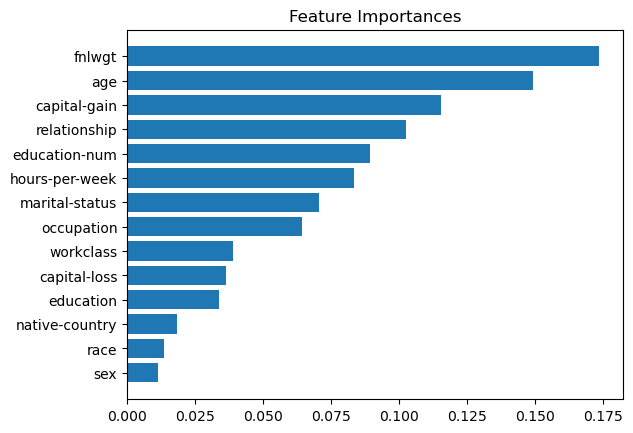

Random Forest Test Data Accuracy = 0.8592


In [13]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(n_estimators=1000)
forest.fit(X_train, y_train)

#Ranking Feature Importances
importances = forest.feature_importances_
indices = np.argsort(importances)
plt.barh(X.columns[indices], importances[indices])
plt.title("Feature Importances");
plt.show()

#Computing Accuracy
forest_test = forest.predict(X_test)
forest_score = accuracy_score(y_test, forest_test)
print(f'Random Forest Test Data Accuracy = {forest_score:.4f}')

## Conclusions

1.   The model was able to correcly classify 85.92% of the test data, which is a modest improvement compared to Linear Regression.
2.   The most important features are fnlwgt, age, and capital gain while the least important features are sex, race, and native country.
3.   Generally categorical features are less important than numerical ones exceptions being that relationship has a high importance for a categorical feature and capital loss has a low importance for a numerical one. A possible explanation for each is that relationship within a household could make a difference as to who is expected to earn money (e.g. adult children could be supported by the income of their parents while they attend college or look for a career) and capital loss wouldn't be very different between both classes as those making <=50k don't have as much capital to lose while those making >50k have resources to keep their capital secure.

# 7. Conclusion

Throughout this project, we have


*   Introduced the dataset and motivated certain aspects of preprocessing
*   Generated 3 statistical models to identify representation of certain predictors  
*   Found that PCA may not be the best choice for an unsupervised learning model for this data as given by the explained variance ratios
*   Realized that Logistic Regression and Random Forests are both potent supervised learning models in predicting the binary income classes, but Random Forest's accuracy is relatively higher

Some improvements for future projects:
*   Spend more time on the exploratory data analysis, looking at the representation of more than just 6 of our predictors. This would check for any misrepresentation/bias and gives us an idea of which ones to remove, if applicable
*   Race, and possibly sex, should have been removed from the model to account for imbalancing issues
*   Try more models that generate pictures, such as LDA/QDA/Naive Bayes/K-Means (with a much smaller set)
*   Apply at least one resampling method (K-Fold CV, Bootstrapping) to generate more than just "one" model